## Import Libraries

Importing neccessary libraries for the code to run.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from Bio import SeqIO
from Bio.PDB import PDBParser
from Bio.SeqUtils import ProtParamData, molecular_weight


2025-03-22 17:45:33.510663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
df = pd.read_json('data/thermomutdb.json')

print(df.shape)
print(df.columns.to_list())

cols_to_keep = [
    'PDB_wild',
    'protein',
    'ddg',
    'mutation_code',
    'pos',
    'mutation_type',
    'blosum62',
    'pam250',
    'ca_depth',
    'res_depth',
    'relative_bfactor',
    'phi',
    'psi',
    'sst',
    'rsa',
    'temperature',
    'ph',
]

df_filtered = df[cols_to_keep]
df_filtered.to_csv('data/thermomutdb_filtered.csv', index=False)
print(df_filtered.shape)
print(df_filtered.columns.tolist())


(13337, 44)
['DOI', 'weight', 'blosum62', 'measure', 'pos', 'pdbs_template', 'year', 'protein', 'PDBs_template', 'id', 'aro', 'PDB_wild', 'reference', 'ca_depth', 'mut_count', 'neg', 'pdb_mutant', 'sul', 'relative_bfactor', 'mutation_type', 'source', 'mutation_code', 'swissprot', 'mutation_based', 'ph', 'neu', 'ddg', 'method', 'phi', 'psi', 'sst', 'rsa', 'effect', 'mutated_chain', 'res_depth', 'temperature', 'acc', 'don', 'dtm', 'pam250', 'length', 'uniprot', 'PMID', 'PIR_ID']
(13337, 17)
['PDB_wild', 'protein', 'ddg', 'mutation_code', 'pos', 'mutation_type', 'blosum62', 'pam250', 'ca_depth', 'res_depth', 'relative_bfactor', 'phi', 'psi', 'sst', 'rsa', 'temperature', 'ph']


In [33]:
# Extract wild-type and mutant amino acids from mutation code
# "A45G" means residue A at position 45 mutated to G
df_filtered['wild_type'] = df_filtered['mutation_code'].str[0]
df_filtered['mutant'] = df_filtered['mutation_code'].str[-1]

# Missing values
print("\nMissing values in each column:")
print(df_filtered.isnull().sum())

# Handle missing values - fill with median for numerical columns
numerical_cols = ['blosum62', 'pam250', 'ca_depth', 'res_depth', 
                 'relative_bfactor', 'phi', 'psi', 'rsa', 
                 'temperature', 'ph', 'ddg']

for col in numerical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# For categorical columns, fill with mode
categorical_cols = ['sst', 'mutation_type', 'wild_type', 'mutant']
for col in categorical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])

# Drop any remaining rows with NaN values
df_filtered = df_filtered.dropna()
print(f"Dataset after handling missing values: {df_filtered.shape[0]} entries")


Missing values in each column:
PDB_wild            0
protein             0
ddg                 0
mutation_code       0
pos                 0
mutation_type       0
blosum62            0
pam250              0
ca_depth            0
res_depth           0
relative_bfactor    0
phi                 0
psi                 0
sst                 0
rsa                 0
temperature         0
ph                  0
wild_type           0
mutant              0
dtype: int64
Dataset after handling missing values: 10153 entries



Basic statistics for ddG:
count    10153.000000
mean        -1.097591
std          1.930666
min        -23.210000
25%         -1.770335
50%         -0.740000
75%         -0.130000
max         13.700000
Name: ddg, dtype: float64


Text(0, 0.5, 'Frequency')

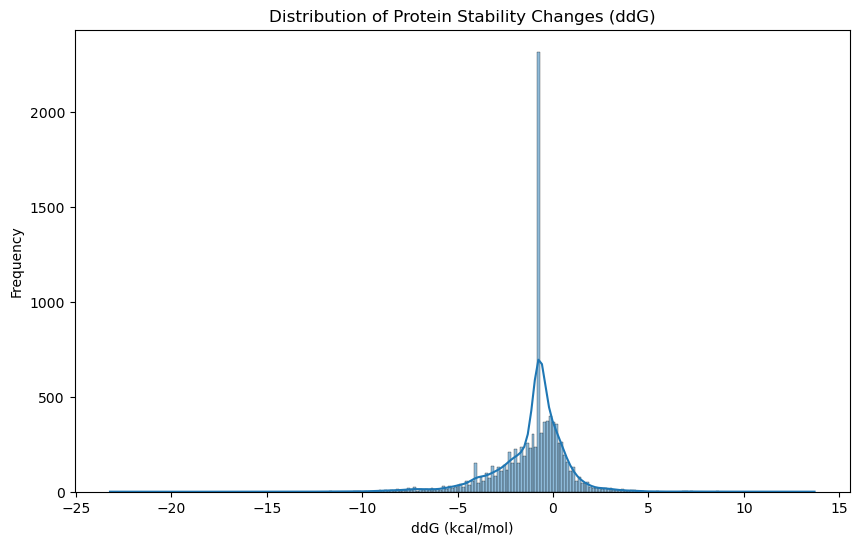

In [29]:
print("\nBasic statistics for ddG:")
print(df_filtered['ddg'].describe())

# Visualize the distribution of ddG values
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['ddg'], kde=True)
plt.title('Distribution of Protein Stability Changes (ddG)')
plt.xlabel('ddG (kcal/mol)')
plt.ylabel('Frequency')

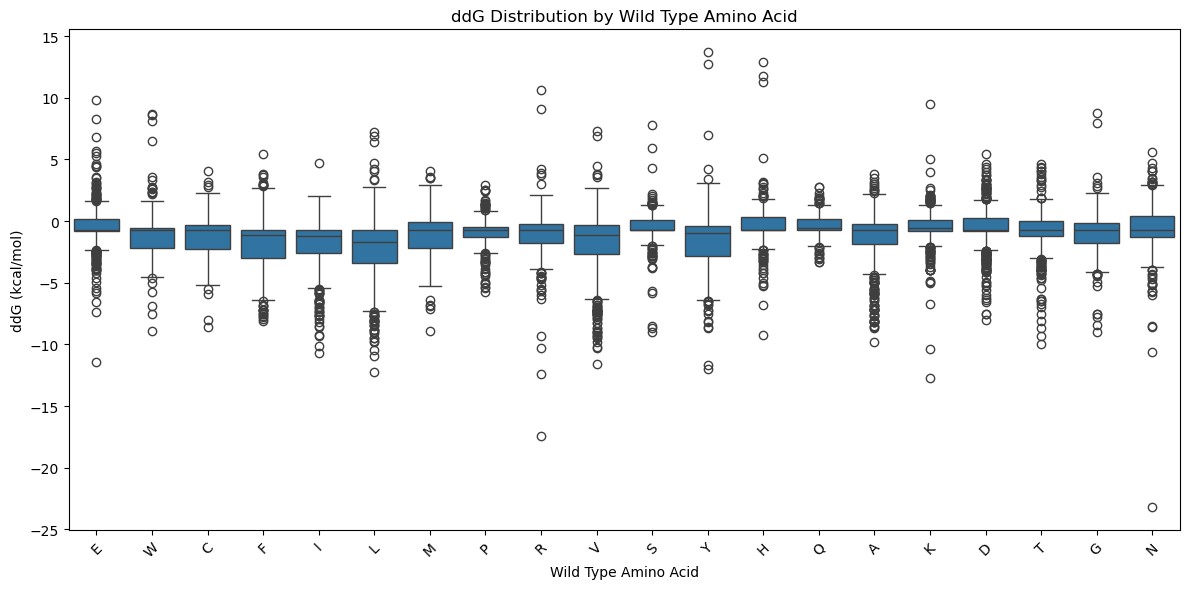

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='wild_type', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Wild Type Amino Acid')
plt.xlabel('Wild Type Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

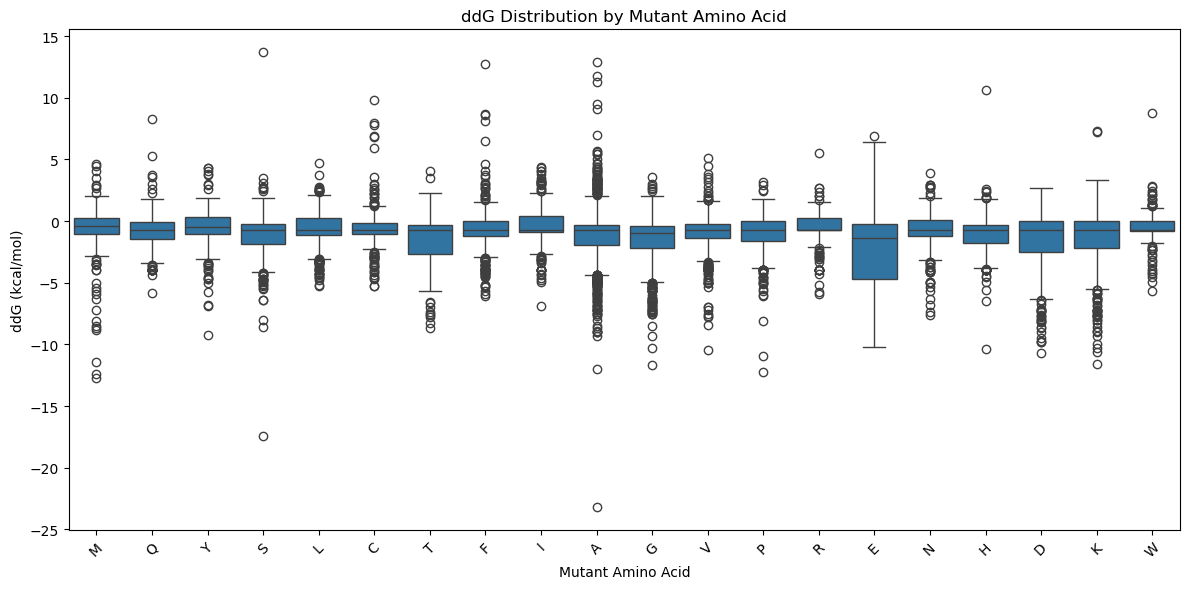

In [31]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='mutant', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Mutant Amino Acid')
plt.xlabel('Mutant Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

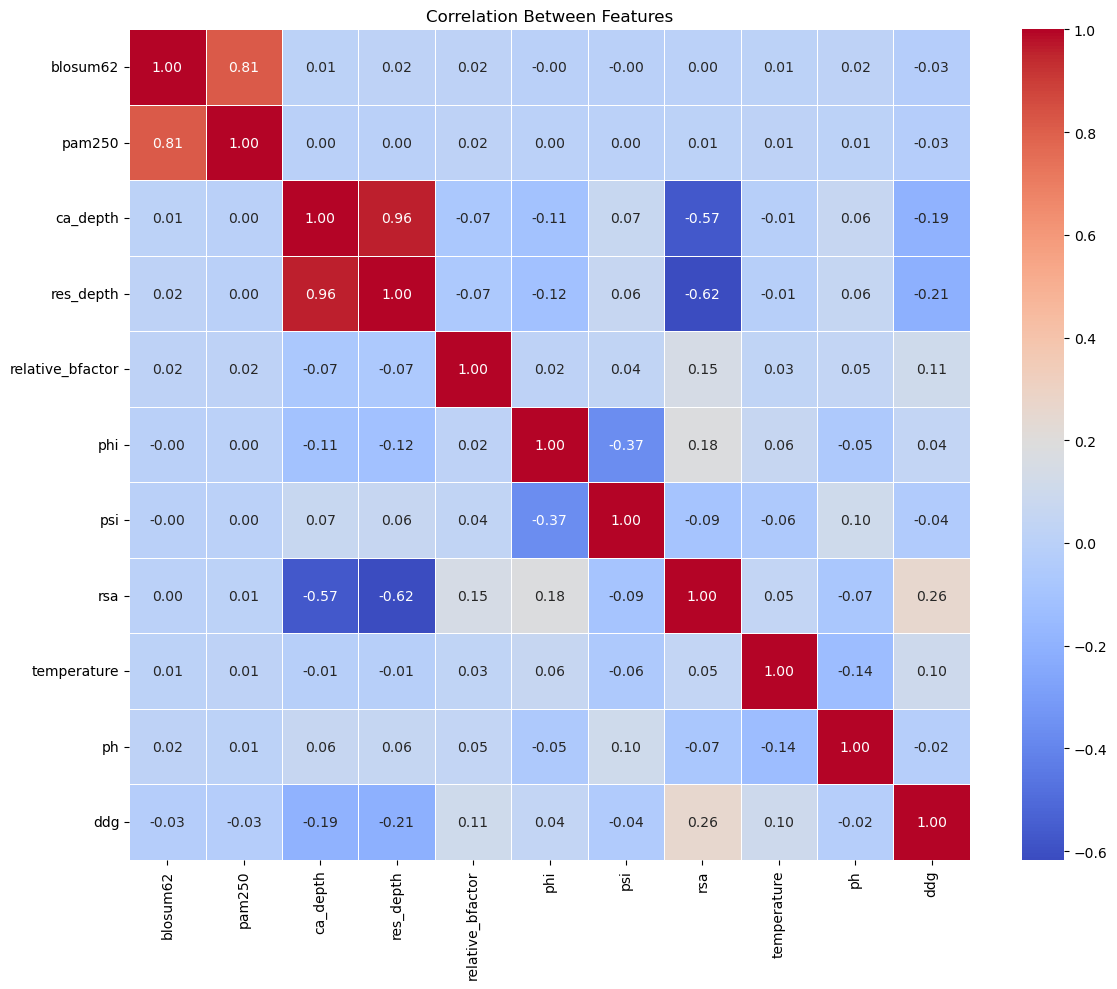

In [34]:
correlation = df_filtered[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Features')
plt.tight_layout()